In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from keras import backend as K

#Clear TF memory
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

C:\Users\StrikeWade\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load customized images dataset

In [2]:
loadpath = "../Basic TF & things/data/custom_data.npz"
l = np.load(loadpath)
print(l.files)
print('')

#Parse data
train_img = l['trainimg']
train_label = l['trainlabel']
test_img = l['testimg']
test_label = l['testlabel']
img_size = l['imgsize']
use_gray = l['use_gray']
n_train = train_img.shape[0]
n_class = train_label.shape[1]
dimension = train_img.shape[1]
n_test = test_img.shape[0]
print ("%d train images loaded" % (n_train))
print ("%d test images loaded" % (n_test))
print ("%d dimensional input" % (dimension))
print ("Image size is %s" % (img_size))
print ("%d classes" % (n_class))

['use_gray', 'testlabel', 'trainlabel', 'testimg', 'trainimg', 'imgsize']

408 train images loaded
273 test images loaded
4096 dimensional input
Image size is [64 64]
4 classes


# Define Params and network params

In [3]:
#Params
learning_rate = 0.001
epochs = 400
batch_size = 100
display_step = 50

#Network Params
n_input = dimension
n_classes = n_class
keep = 0.7

#Placeholder
x = tf.placeholder(dtype=tf.float32, shape=[None, n_input])
y = tf.placeholder(dtype=tf.float32, shape=[None, n_classes])
keep_prob = tf.placeholder(dtype=tf.float32)

#Weights and Biases
stddev = 0.1
if use_gray:
    weights = {
        'wc1': tf.Variable(tf.random_normal(shape=[5,5,1,128], stddev=stddev)),
        'wc2': tf.Variable(tf.random_normal(shape=[5,5,128,128], stddev=stddev)),
        'wd1': tf.Variable(tf.random_normal(shape=[(int)(img_size[0]/4*img_size[1]/4)*128, 128], stddev=stddev)), # #8192 dimension dense layer
        'wd2': tf.Variable(tf.random_normal(shape=[128, n_classes], stddev=stddev))
    }
else:
    weights = {
        'wc1': tf.Variable(tf.random_normal(shape=[5,5,1,128], stddev=stddev)),
        'wc2': tf.Variable(tf.random_normal(shape=[5,5,128,128], stddev=stddev)),
        'wd1': tf.Variable(tf.random_normal(shape=[(int)(img_size[0]/4*img_size[1]/4)*128, 128], stddev=stddev)),
        'wd2': tf.Variable(tf.random_normal(shape=[128, n_classes], stddev=stddev))
    }
    
biases = {
        'bc1': tf.Variable(tf.random_normal([128], stddev=stddev)),
        'bc2': tf.Variable(tf.random_normal([128], stddev=stddev)),
        'bd1': tf.Variable(tf.random_normal([128], stddev=stddev)),
        'bd2': tf.Variable(tf.random_normal([n_classes], stddev=stddev))
    }

# Define CNN function

In [4]:
def conv_basic(x, weights, biases, keep_prob, use_gray):
    #Reshape input to 4-D
    if use_gray:
        input_r = tf.reshape(tensor=x, shape=[-1, img_size[0], img_size[1], 1])
    else:
        input_r = tf.reshape(tensor=x, shape=[-1, img_size[0], img_size[1], 3])
    
    #Convolutional layer 1
    conv1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input=input_r, filter=weights['wc1'], strides=[1,1,1,1], padding='SAME'), bias=biases['bc1']))
    pool1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    pool1_dr = tf.nn.dropout(x=pool1, keep_prob=keep_prob)
    
    #Convolutional layer 2
    conv2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(input=pool1_dr, filter=weights['wc2'], strides=[1,1,1,1], padding='SAME'), bias=biases['bc2']))
    pool2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    pool2_dr = tf.nn.dropout(x=pool2, keep_prob=keep_prob)
    
    #Vectorize
    dense = tf.reshape(tensor=pool2_dr, shape=[-1, weights['wd1'].get_shape().as_list()[0]])
    
    #Fully connected layer 1
    fc1 = tf.nn.relu(tf.add(tf.matmul(dense, weights['wd1']), biases['bd1']))
    fc1_dr = tf.nn.dropout(x=fc1, keep_prob=keep_prob)
    
    #Fully connected layer 2
    out = tf.add(tf.matmul(fc1_dr, weights['wd2']), biases['bd2'])
    
    #Return all layers
    out = {
        'input_r': input_r,
        'conv1': conv1,
        'pool1': pool1,
        'pool1_dr': pool1_dr,
        'conv2': conv2,
        'pool2': pool2,
        'pool2_dr': pool2_dr,
        'dense': dense,
        'fc1': fc1,
        'fc1_dr': fc1_dr,
        'out': out,
    }
    
    return out

# Define other functions to train and predict

In [5]:
y_pred = conv_basic(x=x, weights=weights, biases=biases, keep_prob=keep_prob, use_gray=use_gray)['out']

#Loss and optimizer functions
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y))
WEIGHT_DECAY_FACTOR = 0.0001 #Use for custom images dataset
l2_loss = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables()])
loss += WEIGHT_DECAY_FACTOR*l2_loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

#Correct pred and accuracy function
correct_pred = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(x=correct_pred, dtype=tf.float32))

#Init function
init = tf.global_variables_initializer()

#Saver function to save model
save_step = 1
saver = tf.train.Saver(max_to_keep=3)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



# Training Phase

In [6]:
do_train = 1
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)

In [7]:
for epoch in range(epochs):
    avg_loss = 0
    total_batch = int(n_train/batch_size)+1
    
    #Loop over all batches
    for i in range(total_batch):
        #Define batch_x and batch_y to train
        rand_idx = np.random.randint(n_train, size=batch_size)
        batch_x = train_img[rand_idx, :]
        batch_y = train_label[rand_idx, :]
        
        #Fit training use batch data
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob:keep})
        
        #Compute avg_loss
        avg_loss += sess.run(loss, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0}) / total_batch
        
    #Display logs per epoch step
    if epoch % display_step == 0 or epoch == epochs-1:
        print('Epoch %03d/%03d,    loss = %.4f' % (epoch, epochs, avg_loss))
        train_accuracy = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        test_accuracy = sess.run(accuracy, feed_dict={x: test_img, y: test_label, keep_prob: 1.0})
        
        print('-->    Train Accuracy: ', train_accuracy)
        print('-->    Test Accuracy: ', test_accuracy)
    
    #Save model
    if epoch % save_step == 0:
        saver.save(sess=sess, save_path= 'saved_models/cnn_custom_basic.ckpt-' + str(epoch))
        
print('Final Accuracy on test set is: ', test_accuracy)

Epoch 000/400,    loss = 14.5482
-->    Train Accuracy:  0.83
-->    Test Accuracy:  0.7765568
Epoch 050/400,    loss = 2.0652
-->    Train Accuracy:  0.99
-->    Test Accuracy:  0.93406594
Epoch 100/400,    loss = 1.8741
-->    Train Accuracy:  1.0
-->    Test Accuracy:  0.92673993
Epoch 150/400,    loss = 1.7048
-->    Train Accuracy:  1.0
-->    Test Accuracy:  0.94139194
Epoch 200/400,    loss = 1.5480
-->    Train Accuracy:  1.0
-->    Test Accuracy:  0.93772894
Epoch 250/400,    loss = 1.4037
-->    Train Accuracy:  1.0
-->    Test Accuracy:  0.93406594
Epoch 300/400,    loss = 1.2703
-->    Train Accuracy:  1.0
-->    Test Accuracy:  0.93772894
Epoch 350/400,    loss = 1.1480
-->    Train Accuracy:  1.0
-->    Test Accuracy:  0.9194139
Epoch 399/400,    loss = 1.0361
-->    Train Accuracy:  1.0
-->    Test Accuracy:  0.94139194
Final Accuracy on test set is:  0.94139194


# Build confusion matrix

In [17]:
#Build Confusion matrix plot function

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
#y_test labels and predicted test labels from the model
y_test = np.argmax(test_label, 1)
print('Array of all labels: ', y_test)
print('Shape: ', y_test.shape)

y_predicted = sess.run(y_pred, feed_dict={x: test_img, y: test_label, keep_prob: 1.0})
y_predicted = np.argmax(y_predicted, 1)
print('Array of all predicted labels: ', y_predicted)
print('Shape: ', y_predicted.shape)

Array of all labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0
 0 0 3 0 0 0 0 0 0 1 3 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0 0 3 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 3 0 0 2 0 2 1 0 0 0 0 0 0 0 0 1 0 0 2 0 0 1 0
 0 0 0 1 0 0 0 0 0 3 0 0 0 0 0 2 3 3 3 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 3 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 2 3 0 0 1 0 3 0 2 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 2 0 0 1 0 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 3
 2 0 0 0 0 3 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 3 0 0 3 2 1 0 0 0 0 0 3 0]
Shape:  (273,)
Array of all predicted labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 3 3 0 0 0 0 0 0
 0 0 3 0 0 0 0 0 0 1 3 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 3 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 3 0 0 0 0 2 3 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 3 0 0 0 0 0 2 3 0 3 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 3 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 3 0 0 0 0 0 3 0 2 0 0 0 0 0 0
 

In [20]:
cfs_matrix = confusion_matrix(y_pred=y_predicted, y_true=y_test)
cfs.shape

(4, 4)

Confusion matrix, without normalization
[[219   0   0   3]
 [  1  11   0   1]
 [  8   0  10   0]
 [  3   0   0  17]]


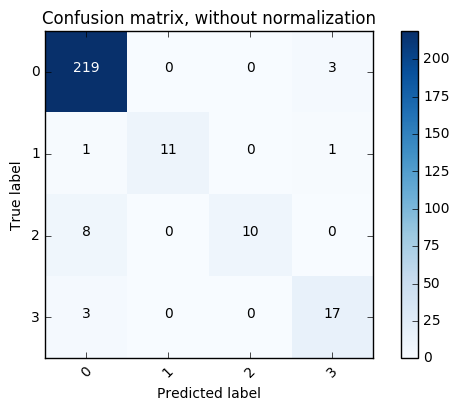

In [21]:
classes_name = np.array(['0','1','2','3'])

#Plot non_normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm=cfs_matrix, classes=classes_name, title='Confusion matrix, without normalization')

# Pick and plot some random test predicted examples

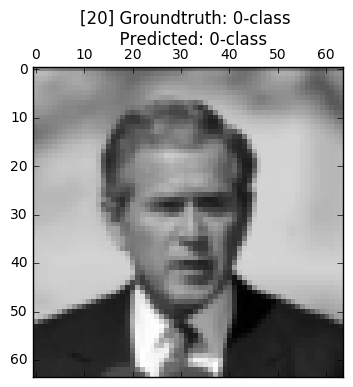

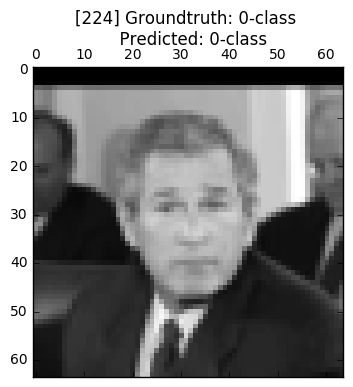

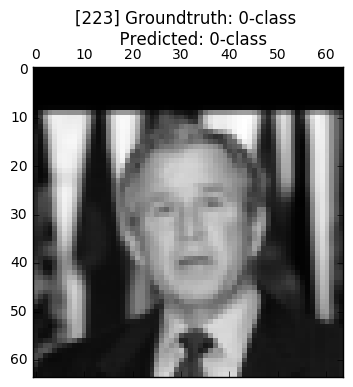

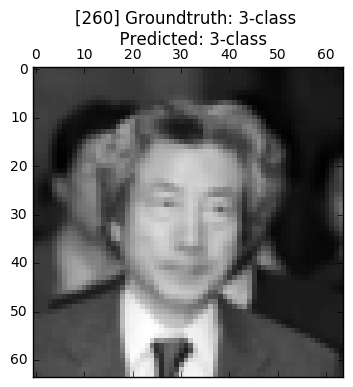

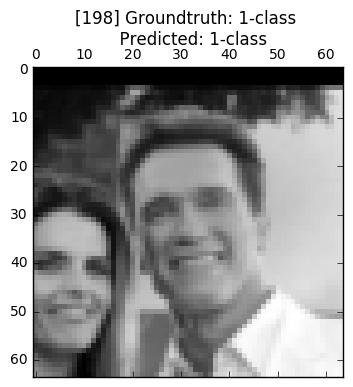

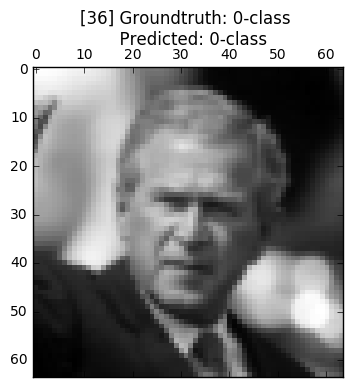

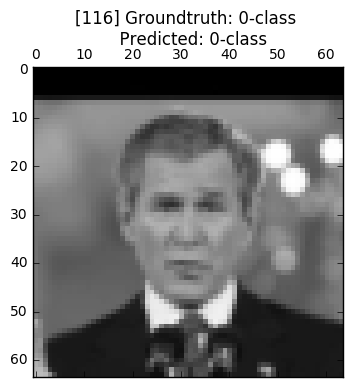

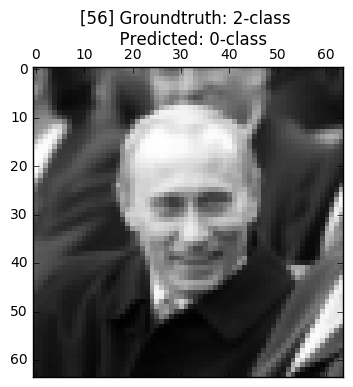

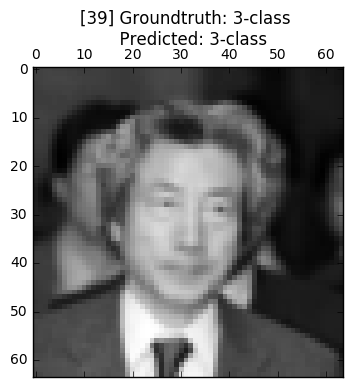

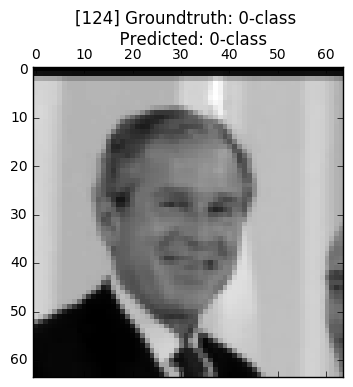

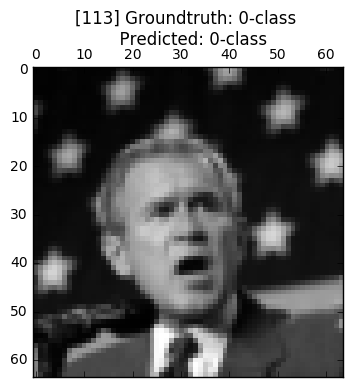

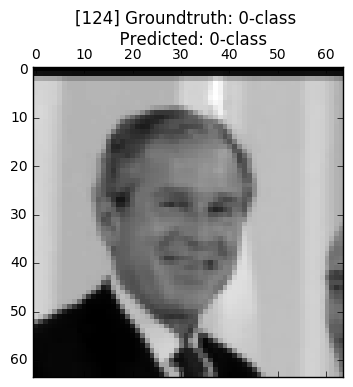

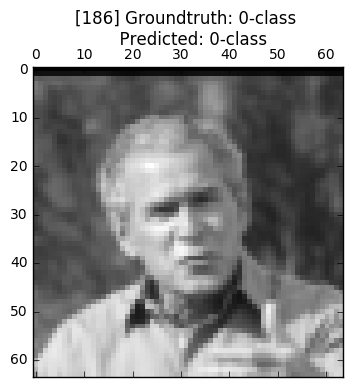

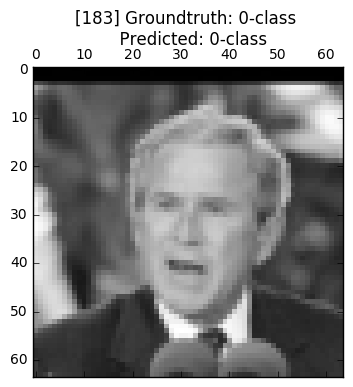

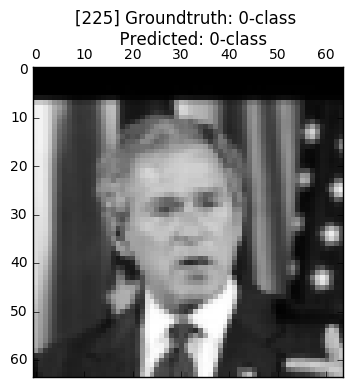

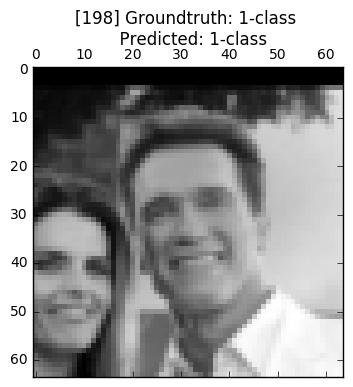

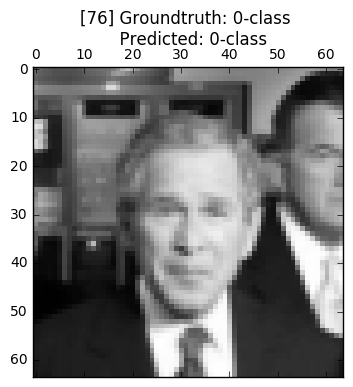

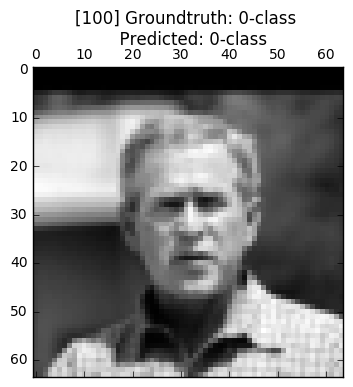

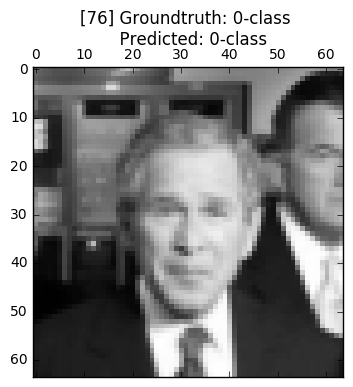

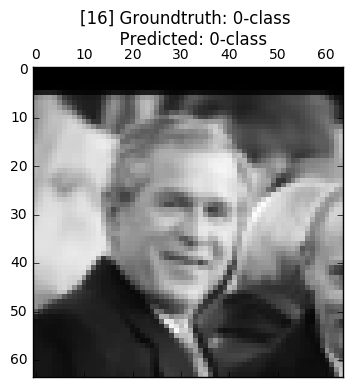

In [28]:
number_test_images = 20
random_idx = np.random.randint(n_test, size=number_test_images)

y_predicted = sess.run(y_pred, feed_dict={x: test_img, y: test_label, keep_prob: 1.0})

for i in random_idx:
    current_img = np.reshape(test_img[i, :], newshape=(img_size[0], -1))
    current_label_onehot = test_label[i, :]
    current_label = np.argmax(current_label_onehot)
    
    current_predicted_label = np.argmax(y_predicted, 1)
    
    plt.matshow(current_img, cmap=plt.get_cmap('gray'))
    
    groundtruth_and_predicted = '[%d] Groundtruth: %d-class \n  Predicted: %d-class' % (i, current_label, current_predicted_label[i])
    plt.title(groundtruth_and_predicted)

Number of mismatch examples:  16
Array of y_true mismatch examples:  [0, 2, 1, 2, 1, 2, 3, 3, 2, 3, 2, 0, 2, 0, 2, 2]
Array of y_pred missmatch examples:  [3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0]


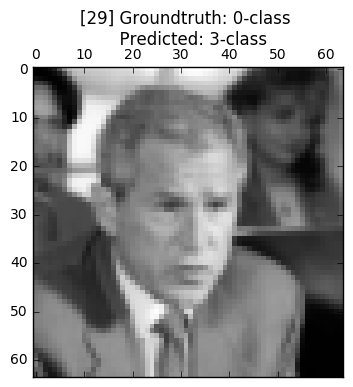

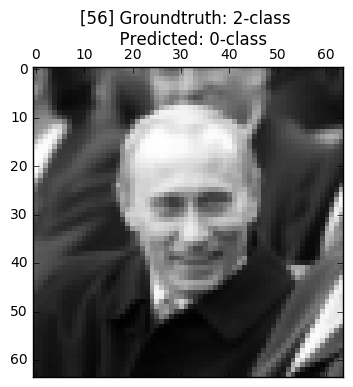

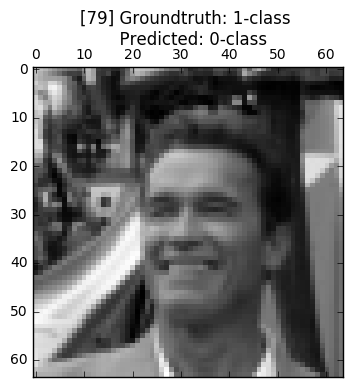

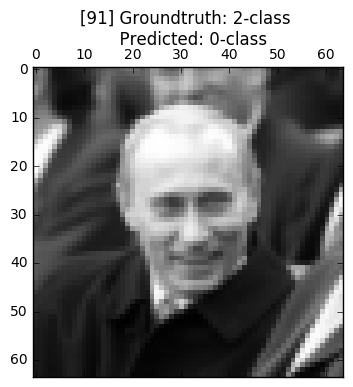

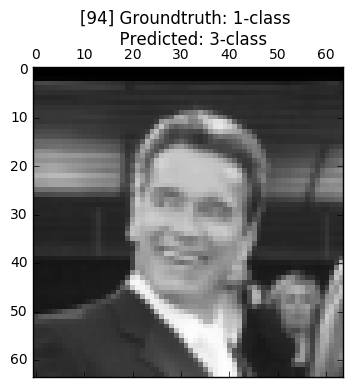

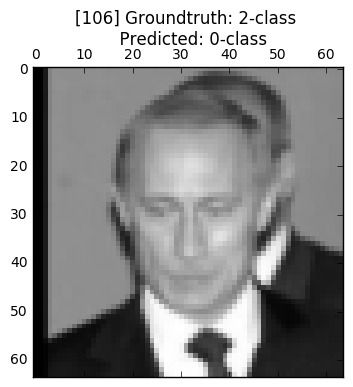

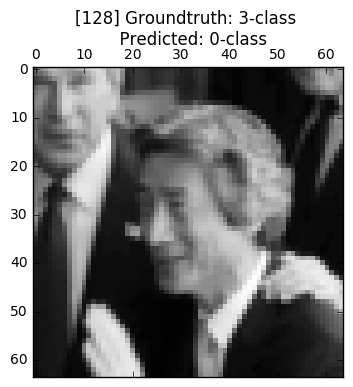

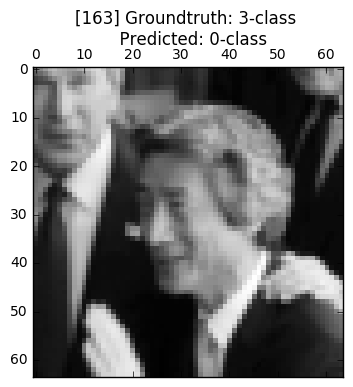

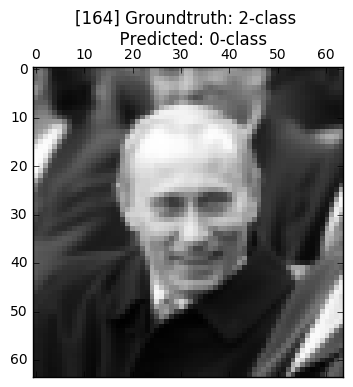

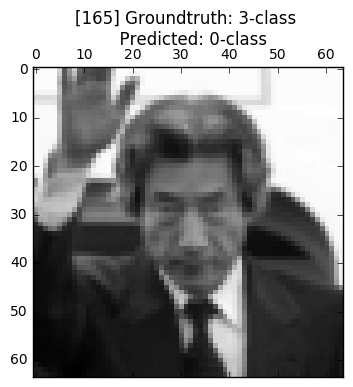

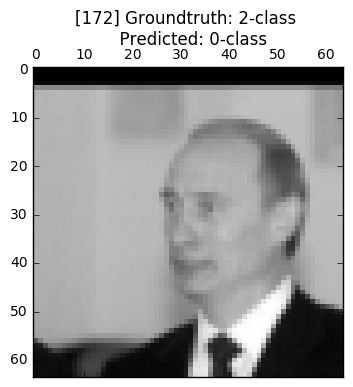

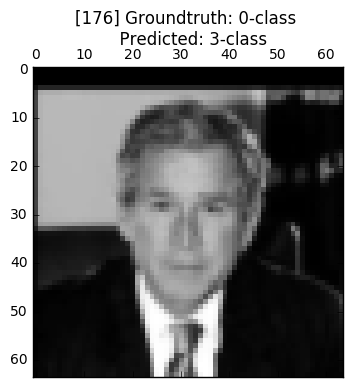

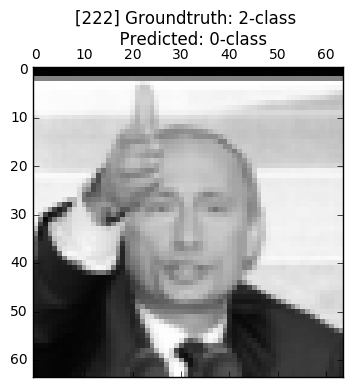

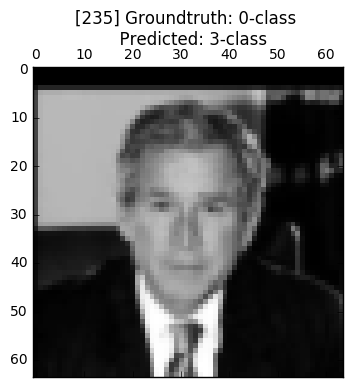

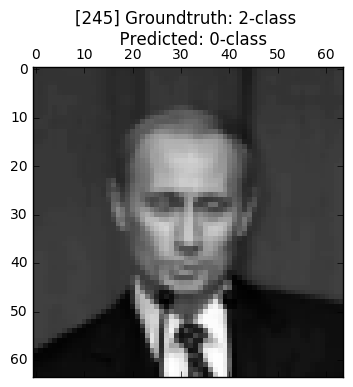

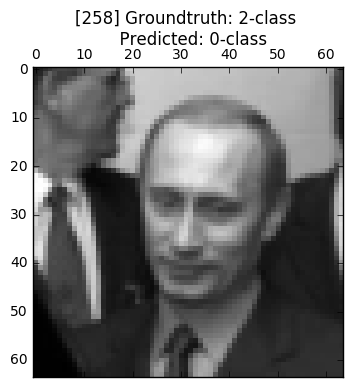

In [39]:
count_mismatch = 0

y_true = []
y_predi = []

for i in range(n_test):
    current_img = np.reshape(test_img[i, :], newshape=(img_size[0], -1))
    current_label_onehot = test_label[i, :]
    current_label = np.argmax(current_label_onehot)
    
    current_predicted_label = np.argmax(y_predicted, 1)
    
    if current_label != current_predicted_label[i]:
        y_true.append(current_label)
        y_predi.append(current_predicted_label[i])
    
        plt.matshow(current_img, cmap=plt.get_cmap('gray'))
        miss_matched = '[%d] Groundtruth: %d-class \n  Predicted: %d-class' % (i, current_label, current_predicted_label[i])
        plt.title(miss_matched)
        
        count_mismatch += 1
        
print('Number of mismatch examples: ', count_mismatch)
print('Array of y_true mismatch examples: ', y_true)
print('Array of y_pred missmatch examples: ', y_predi)
